📊 Distribuição dos valores de cada feature:
            HighBP     HighChol    CholCheck          BMI       Smoker  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.591000     0.530000     0.983000    29.217000     0.446000   
std       0.491895     0.499349     0.129336     6.218085     0.497324   
min       0.000000     0.000000     0.000000    16.000000     0.000000   
25%       0.000000     0.000000     1.000000    25.000000     0.000000   
50%       1.000000     1.000000     1.000000    28.000000     0.000000   
75%       1.000000     1.000000     1.000000    32.000000     1.000000   
max       1.000000     1.000000     1.000000    59.000000     1.000000   

            Stroke  HeartDiseaseorAttack  PhysActivity       Fruits  \
count  1000.000000           1000.000000   1000.000000  1000.000000   
mean      0.066000              0.134000      0.636000     0.578000   
std       0.248406              0.340823      0.481389     0.494126   
min  

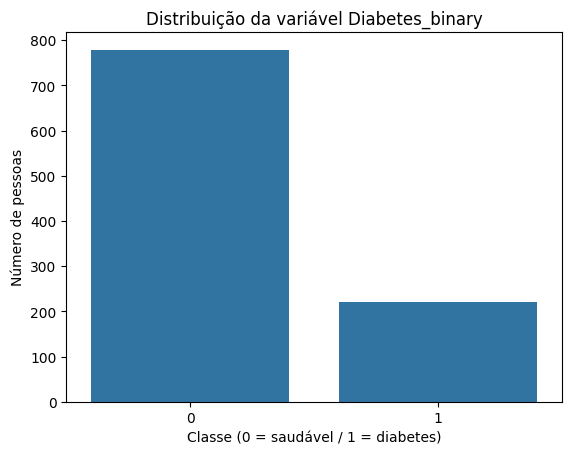


🔎 Variância das features:
CholCheck                0.016728
HvyAlcoholConsump        0.030069
AnyHealthcare            0.040276
Stroke                   0.061706
NoDocbcCost              0.092483
HeartDiseaseorAttack     0.116160
Veggies                  0.188187
DiffWalk                 0.212187
Sex                      0.227123
PhysActivity             0.231736
HighBP                   0.241961
Fruits                   0.244160
Smoker                   0.247331
HighChol                 0.249349
Education                1.108748
GenHlth                  1.208520
Income                   4.978754
Age                      7.111350
BMI                     38.664576
MentHlth                70.434305
PhysHlth                98.587832
dtype: float64

⚖️ Proporção das classes em y (Diabetes_binary):
Diabetes_binary
0    0.779
1    0.221
Name: proportion, dtype: float64

🧩 Features com baixa variância (< 0.01):
Series([], dtype: float64)


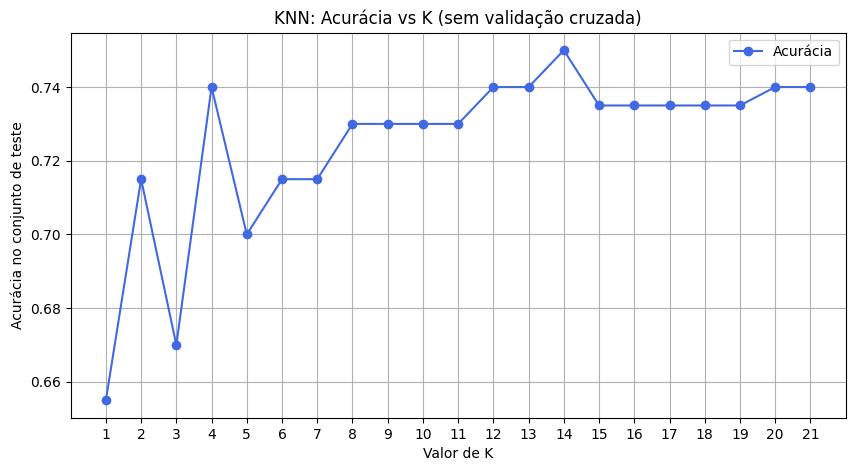

Melhor valor de K: 14 com acurácia 0.7500


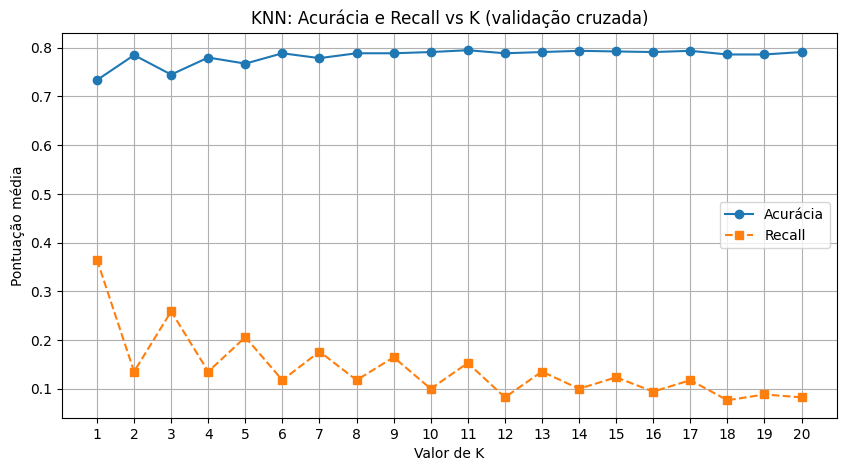

In [2]:
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline



# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
#print(cdc_diabetes_health_indicators.metadata)

# variable information
#print(cdc_diabetes_health_indicators.variables)


y = y["Diabetes_binary"]

X = X.head(1000)
y = y.head(1000)
# print(X.head(10))

def diagnostico_dataset(X, y):
    print("📊 Distribuição dos valores de cada feature:")
    print(X.describe())
    sns.countplot(x=y)
    plt.title("Distribuição da variável Diabetes_binary")
    plt.xlabel("Classe (0 = saudável / 1 = diabetes)")
    plt.ylabel("Número de pessoas")
    plt.show()

    print("\n🔎 Variância das features:")
    print(X.var().sort_values())

    print("\n⚖️ Proporção das classes em y (Diabetes_binary):")
    print(y.value_counts(normalize=True))

    print("\n🧩 Features com baixa variância (< 0.01):")
    baixa_var = X.var()[X.var() < 0.01]
    print(baixa_var)

diagnostico_dataset(X, y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def melhor_knn_acuracia():
    k_values = range(1, 22)
    accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

    plt.figure(figsize=(10, 5))
    plt.plot(k_values, accuracies, marker='o', label="Acurácia", color="royalblue")
    plt.xlabel("Valor de K")
    plt.ylabel("Acurácia no conjunto de teste")
    plt.title("KNN: Acurácia vs K (sem validação cruzada)")
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

    best_k = k_values[np.argmax(accuracies)]
    maior = max(accuracies)
    print(f"Melhor valor de K: {best_k} com acurácia {maior:.4f}")

melhor_knn_acuracia()


def melhor_knn_valid_cruzada():
    k_values = range(1, 21)
    accuracies = []
    recalls = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        acc = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        recall = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='recall').mean()

        accuracies.append(acc)
        recalls.append(recall)

    plt.figure(figsize=(10, 5))
    plt.plot(k_values, accuracies, marker='o', label="Acurácia")
    plt.plot(k_values, recalls, marker='s', label="Recall", linestyle='--')
    plt.xlabel("Valor de K")
    plt.ylabel("Pontuação média")
    plt.title("KNN: Acurácia e Recall vs K (validação cruzada)")
    plt.xticks(k_values)
    plt.legend()
    plt.grid(True)
    plt.show()

melhor_knn_valid_cruzada()

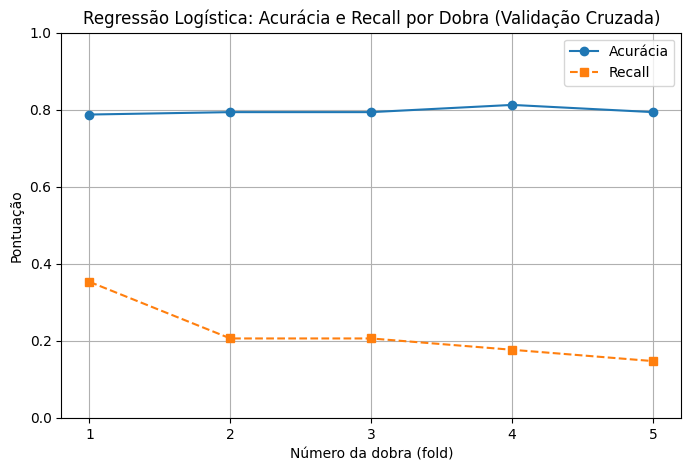

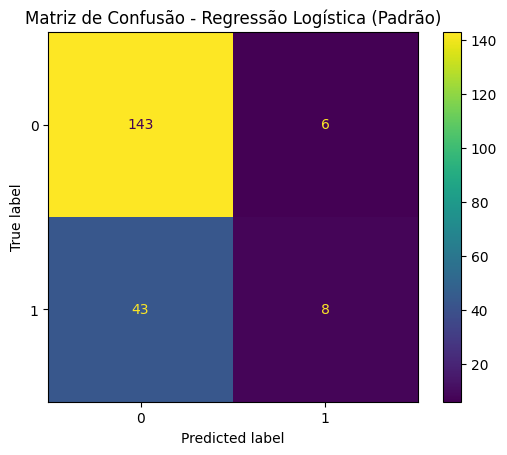

🔍 Melhor combinação de hiperparâmetros: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}


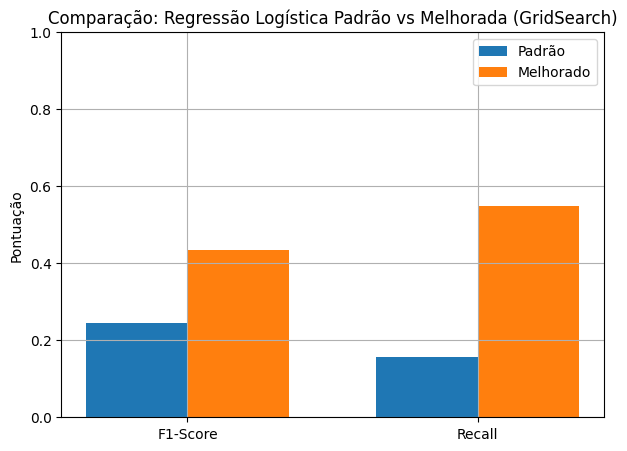

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score



def avalia_logreg_pontuacoes(X_train_scaled, y_train):
    model = LogisticRegression(solver='liblinear')

    acc = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    recall = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='recall')

    return acc, recall

def plota_resultado_logreg(acc_scores, recall_scores):
    folds = range(1, len(acc_scores) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(folds, acc_scores, marker='o', label="Acurácia")
    plt.plot(folds, recall_scores, marker='s', label="Recall", linestyle='--')
    plt.title("Regressão Logística: Acurácia e Recall por Dobra (Validação Cruzada)")
    plt.xlabel("Número da dobra (fold)")
    plt.ylabel("Pontuação")
    plt.ylim(0, 1)
    plt.xticks(folds)
    plt.grid(True)
    plt.legend()
    plt.show()

acc_scores, recall_scores = avalia_logreg_pontuacoes(X_train_scaled, y_train)
plota_resultado_logreg(acc_scores, recall_scores)



# Instancia e treina o modelo
logreg = LogisticRegression(solver="liblinear")
logreg.fit(X_train_scaled, y_train)

# Previsões
y_pred = logreg.predict(X_test_scaled)

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusão - Regressão Logística (Padrão)")
plt.show()





# Define o modelo base
logreg = LogisticRegression(solver="liblinear")

# Grade de hiperparâmetros a testar
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

# Busca com validação cruzada
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

# Melhor modelo e seus parâmetros
best_model = grid.best_estimator_
print("🔍 Melhor combinação de hiperparâmetros:", grid.best_params_)




def compara_modelos(modelo1, modelo2, X_test_scaled, y_test):
    y_pred1 = modelo1.predict(X_test_scaled)
    y_pred2 = modelo2.predict(X_test_scaled)

    f1_1 = f1_score(y_test, y_pred1)
    f1_2 = f1_score(y_test, y_pred2)

    recall_1 = recall_score(y_test, y_pred1)
    recall_2 = recall_score(y_test, y_pred2)

    plt.figure(figsize=(7, 5))
    bar_width = 0.35
    labels = ['F1-Score', 'Recall']

    plt.bar(np.arange(2), [f1_1, recall_1], width=bar_width, label='Padrão')
    plt.bar(np.arange(2) + bar_width, [f1_2, recall_2], width=bar_width, label='Melhorado')

    plt.xticks(np.arange(2) + bar_width / 2, labels)
    plt.ylabel("Pontuação")
    plt.ylim(0, 1)
    plt.title("Comparação: Regressão Logística Padrão vs Melhorada (GridSearch)")
    plt.legend()
    plt.grid(True)
    plt.show()



# Modelo padrão
modelo_padrao = LogisticRegression(solver="liblinear")
modelo_padrao.fit(X_train_scaled, y_train)

# Melhor modelo com hiperparâmetros
modelo_melhorado = grid.best_estimator_

# Comparar
compara_modelos(modelo_padrao, modelo_melhorado, X_test_scaled, y_test)

